In [ ]:
import numpy as np
import sys,csv,os
from datetime import datetime
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras  as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

csv.field_size_limit(sys.maxsize)
#%load_ext tensorboard
#logs_base_dir = "./logs"
#os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir}
tf.compat.v1.disable_eager_execution()
K.clear_session()
!nvidia-smi

Thu Oct  8 14:35:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load hyperparameters

In [ ]:
ENCODER_TYPE = "ENCODER_CONV"
DECODER_TYPE = "DECODER_CONV"
DISCR_TYPE = "DISCR_CONV"
NUMBER_OF_APPAREL = 27
NUMBER_OF_REDUCED_APPAREL = 13
NUMBER_OF_CATEGORIES = NUMBER_OF_APPAREL
TRAIN_SPLIT = 0.95
IMG_SHAPE = (256,256)
LATENT_DIM=256
INPUT_SHAPE = IMG_SHAPE+(3,)
CHANNEL_FORMAT = 'channels_last' # channel_first better
BATCH_SIZE=112
UNZIP_DATA = True
DIR = '/content/drive/My\ Drive/SDD'
DATA_DIR = DIR + '/extract_clothind_dataset/small'
CHECKPOINT_DIR = DIR+'/checkpoints/FeatExtr'
REDUCE_CATEGORIES=True
USE_VAR_AUTOENCODER=True
if(REDUCE_CATEGORIES==True):  
                              NUMBER_OF_CATEGORIES = NUMBER_OF_REDUCED_APPAREL
                              CATEGORIES={0:'background',1:'shirt,top',2:'sweater,cardigan',
                                          3:'jacket',4:'vest',5:'pants,shorts,skirt',
                                          6:'coat',7:'dress',8:'other',9:'head accesory',
                                          10:'tie',11:'shoe',12:'bag',13:'accessory'}

K.clear_session()

# Load your dataset here

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
if(UNZIP_DATA==True):
  %cd /content
  !cp "/content/drive/My Drive/SDD/extract_clothind_dataset/small.zip" .
  !unzip -q small.zip
  !rm small.zip
  DATA_DIR = "/content/small"

Mounted at /content/drive
/content


In [ ]:
seed=1
image_datagen = image.ImageDataGenerator(                      
                      validation_split=1-TRAIN_SPLIT,
                      rescale=1./255,
                      horizontal_flip=True
                      )

train_gen = image_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset='training',      
        seed=seed)
val_gen = image_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset='validation',      
        seed=seed)

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)
print("Steps per epoch: "+str(steps_per_epoch))

Found 44124 images belonging to 13 classes.
Found 2314 images belonging to 13 classes.
Steps per epoch: 394


# Create custom autoencoder

In [ ]:
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,BatchNormalization,Lambda, Concatenate
from tensorflow.keras.layers import Input,Flatten,Reshape,Conv2D,Conv2DTranspose,ReLU,MaxPool2D
from tensorflow.keras.models import Model,load_model


K.clear_session()
def create_model(input_dim, latent_dim, encoder_sampling=True,load_models=False):
  def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * eps
  autoencoder_input = Input(shape=input_dim)
  generator_input = Input(shape=input_dim)
  categorical_input = Input(shape=(NUMBER_OF_CATEGORIES,))

  if(load_models==False):
    encoder_input = Input(shape=input_dim)
    #encoder_x = Flatten()(encoder_input)
    encoder_x = Conv2D(32,kernel_size=5,strides=(2,2),padding='same')(encoder_input)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)

    encoder_x = Conv2D(64,kernel_size=3,strides=(1,1),padding='same')(encoder_x)
    encoder_x = Conv2D(64,kernel_size=3,strides=(2,2),padding='same')(encoder_x)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)

    encoder_x = Conv2D(128,kernel_size=3,strides=(1,1),padding='same')(encoder_x)
    encoder_x = Conv2D(128,kernel_size=3,strides=(2,2),padding='same')(encoder_x)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)
    
    encoder_x = Conv2D(256,kernel_size=3,strides=(1,1),padding='same')(encoder_x)
    encoder_x = Conv2D(256,kernel_size=3,strides=(2,2),padding='same')(encoder_x)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)

    encoder_x = Conv2D(512,kernel_size=3,strides=(1,1),padding='same')(encoder_x)
    encoder_x = Conv2D(512,kernel_size=3,strides=(2,2),padding='same')(encoder_x)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)

    encoder_x = Conv2D(512,kernel_size=3,strides=(1,1),padding='same')(encoder_x)
    encoder_x = Conv2D(512,kernel_size=3,strides=(2,2),padding='same')(encoder_x)
    encoder_x = BatchNormalization()(encoder_x)
    encoder_x = ReLU()(encoder_x)

    encoder_x = Flatten()(encoder_x)
    if(encoder_sampling==True):
      z_mean = Dense(latent_dim,name='z_mean')(encoder_x)
      z_log_sigma = Dense(latent_dim,name='z_log_sigma')(encoder_x)
      encoder_out = Lambda(sample_z)([z_mean, z_log_sigma])
      autoencoder_additional_output = [Concatenate(axis=1,name="encoding")([z_mean,z_log_sigma])]
    else:
      encoder_out = Dense(latent_dim, activation=None)(encoder_x)
      autoencoder_additional_output = [encoder_out]
    encoder = Model(encoder_input,encoder_out,name='encoder')
    encoder.summary()

    decoder_style_input = Input(shape=(latent_dim,))
    decoder_cat_input = Input(shape=(NUMBER_OF_CATEGORIES,))
    decoder_x = K.concatenate([decoder_style_input,decoder_cat_input])
    decoder_x = Dense(4*4*512, activation='relu')(decoder_x)
    decoder_x = Reshape((4,4,512))(decoder_x)

    decoder_x = Conv2DTranspose(256, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_x = Conv2DTranspose(256, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_x = Conv2DTranspose(128, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_x = Conv2DTranspose(128, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_x = Conv2DTranspose(64, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_x = Conv2DTranspose(64, 3, strides=2,padding='same',use_bias=False)(decoder_x)
    decoder_x = BatchNormalization()(decoder_x)
    decoder_x = ReLU()(decoder_x)

    decoder_out = Conv2D(3, 1, strides=1,padding='same',use_bias=False,name="reconstruction")(decoder_x)
    decoder = Model([decoder_style_input,decoder_cat_input],decoder_out,name='decoder')
    decoder.summary()
    if(USE_VAR_AUTOENCODER==False):
      discr_input = Input(shape=(latent_dim,))
      discr_x = Dense(512, activation='relu')(discr_input)
      discr_x = Dense(256, activation='relu')(discr_x)
      discr_out = Dense(1, activation='sigmoid')(discr_x)
      discriminator = Model(discr_input,discr_out)
  else:
    if(USE_VAR_AUTOENCODER==False):
      discriminator = load_model(CHECKPOINT_DIR+"/"+DISCR_TYPE)
      encoder = load_model(CHECKPOINT_DIR+"/"+ENCODER_TYPE)
      decoder = load_model(CHECKPOINT_DIR+"/"+DECODER_TYPE)
    else:
      print("LOading autoencoder model!")
      autoencoder=load_model('/content/drive/My Drive/SDD/checkpoints/FeatExtr/autoencoder', custom_objects={'kl_loss': kl_loss})
      return autoencoder, None, None, None, None

  encoding = encoder(autoencoder_input)
  reconstruction = decoder([encoder_out,categorical_input])
  autoencoder = Model(inputs=[encoder_input,categorical_input],
                      outputs=[reconstruction]+autoencoder_additional_output,
                      name='vae_autoencoder')
  if(USE_VAR_AUTOENCODER==False):
    full_model = Model([autoencoder_input,categorical_input],
                     [decoder([enocoding,categorical_input])
                     ,discriminator(enocoding)])

    return autoencoder, discriminator, full_model, encoder, decoder
  else:
    return autoencoder, None, None, encoder, decoder

# Define losses, including Kullback-Leibler Div

In [ ]:
beta = K.variable(value=0.001)
beta._trainable = False
wamp_up_epochs = float(30)
def masked_mse_loss(y_true,y_pred):
  loss = (y_pred-y_true)*(y_pred-y_true)
  zero = tf.constant(0, dtype=tf.float32)
  where = tf.not_equal(y_true, zero)
  masked_loss = tf.boolean_mask(loss,where)
  return masked_loss
def kl_loss_warmup(y_true,y_pred):
  z_mean = y_pred[:,:LATENT_DIM]
  z_log_sigma = y_pred[:,LATENT_DIM:]
  kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
  return beta * kl_loss
def kl_loss(y_true,y_pred):
  z_mean = y_pred[:,:LATENT_DIM]
  z_log_sigma = y_pred[:,LATENT_DIM:]
  kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
  return kl_loss
def warmup(epoch):
    value = (epoch/wamp_up_epochs) * (epoch <= wamp_up_epochs) + 1.0 * (epoch > wamp_up_epochs)
    print("WarmUp-beta: "+str(value))
    K.set_value(beta,value)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint, LambdaCallback

cb_checkpoint =ModelCheckpoint("/content/drive/My Drive/SDD/autoencoder",save_weights_only=True,verbose=1,save_best_only=True,monitor='val_loss')
cb_warmup = LambdaCallback(on_epoch_end=lambda epoch, log: warmup(epoch))
K.set_value(beta,1.0)
callbacks=[cb_checkpoint,cb_warmup]


autoencoder, discriminator, full_model, encoder, decoder = create_model(INPUT_SHAPE, 
                                                                        LATENT_DIM,
                                                                        encoder_sampling=True,
                                                                        load_models=False)
normal_graph = tf.compat.v1.get_default_graph()  # only needed as we use 2 models at once


#autoencoder=load_model('/content/drive/My Drive/SDD/checkpoints/FeatExtr/autoencoder_masked', custom_objects={"masked_mse_loss":masked_mse_loss,'kl_loss_warmup': kl_loss_warmup})
if(USE_VAR_AUTOENCODER==True):
  losses = {"decoder":'mse',"encoding":kl_loss_warmup}
  autoencoder.compile(optimizer=Adam(lr=1e-4),loss = losses,loss_weights=[128.0,1.0])
else:
  discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy",metrics=["binary_accuracy"])
  discriminator.trainable = False
  full_model.compile(optimizer=Adam(lr=1e-4), loss=["mse","binary_crossentropy"],loss_weights=[0.995, 0.005])


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 128, 128, 32) 2432        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 128, 128, 32) 128         conv2d_44[0][0]                  
__________________________________________________________________________________________________
re_lu_48 (ReLU)                 (None, 128, 128, 32) 0           batch_normalization_48[0][0]     
____________________________________________________________________________________________

In [ ]:
def data_gen(_gen):
  while(True):
    samples = next(_gen)
    yield [samples[0],samples[1]],[samples[0],np.zeros((samples[0].shape[0],2*LATENT_DIM))]

# Fit model

In [ ]:
autoencoder_history = autoencoder.fit(x=data_gen(train_gen),
                                      epochs=100,
                                      steps_per_epoch=len(train_gen),
                                      initial_epoch=0,
                                      verbose=1,
                                      validation_data=data_gen(val_gen),
                                      validation_steps=len(val_gen),
                                      callbacks=callbacks)

Epoch 1/100
394/394 [==============================] - ETA: 0s - batch: 196.5000 - size: 111.9898 - loss: 8.0669 - decoder_loss: 0.0629 - encoding_loss: 0.0140
Epoch 00001: val_loss improved from inf to 7.96724, saving model to /content/drive/My Drive/SDD/autoencoder
WarmUp-beta: 0.0
394/394 [==============================] - 483s 1s/step - batch: 196.5000 - size: 111.9898 - loss: 8.0669 - decoder_loss: 0.0629 - encoding_loss: 0.0140 - val_loss: 7.9672 - val_decoder_loss: 0.0622 - val_encoding_loss: 0.0026
Epoch 2/100
394/394 [==============================] - ETA: 0s - batch: 196.5000 - size: 111.9898 - loss: 2.7630 - decoder_loss: 0.0216 - encoding_loss: 0.0000e+00
Epoch 00002: val_loss improved from 7.96724 to 2.69156, saving model to /content/drive/My Drive/SDD/autoencoder
WarmUp-beta: 0.03333333333333333
394/394 [==============================] - 477s 1s/step - batch: 196.5000 - size: 111.9898 - loss: 2.7630 - decoder_loss: 0.0216 - encoding_loss: 0.0000e+00 - val_loss: 2.6916 - v

# Add GAN discriminator to enhance the results

In [ ]:
def train(batch_size, n_epochs):
  past = datetime.now()
  autoencoder_epoch_losses=[]
  for epoch in np.arange(1, n_epochs + 1):
    autoencoder_batch_losses = []	
    discriminator_batch_losses = []
    full_model_batch_losses = []
    for batch in np.arange(steps_per_epoch):
      samples = next(train_gen)
      fake_style = encoder.predict(samples[0])
      discriminator_input = np.concatenate((fake_style, np.random.randn(batch_size, LATENT_DIM) * 5.))
      discriminator_labels = np.concatenate((np.zeros((fake_style.shape[0], 1)), np.ones((batch_size, 1))))
      discriminator_history = discriminator.fit(x=discriminator_input, y=discriminator_labels, epochs=1, batch_size=batch_size, verbose=0)
      full_model_history = full_model.fit(x=samples, y=[samples[0],np.ones((samples[0].shape[0], 1))], epochs=1, batch_size=batch_size, verbose=0)

      discriminator_batch_losses.append(discriminator_history.history["loss"])
      full_model_batch_losses.append(full_model_history.history["loss"])
    now = datetime.now()
    print("\nEpoch {}/{} - {:.1f}s".format(epoch, n_epochs, (now - past).total_seconds()))
    print("Discriminator Loss: {}".format(np.mean(discriminator_batch_losses)))
    print("Generator Loss: {}".format(np.mean(full_model_batch_losses[1])))
    past = now
  return autoencoder_epoch_losses

In [ ]:
autoencoder.save('/content/drive/My Drive/SDD/checkpoints/FeatExtr/autoencoder_masked')


INFO:tensorflow:Assets written to: /content/drive/My Drive/SDD/checkpoints/FeatExtr/autoencoder_masked/assets


# Visualize the reconstruction results

In [ ]:
batch = next(val_gen)
y_pred = autoencoder.predict(batch)[0]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [ ]:
y_pred_cat = []
for i in range(13):
  category_array = np.zeros(batch[1].shape)
  category_array[:,i]=1
  y_pred_cat.append(masked_autoencoder.predict([batch[0],category_array])[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


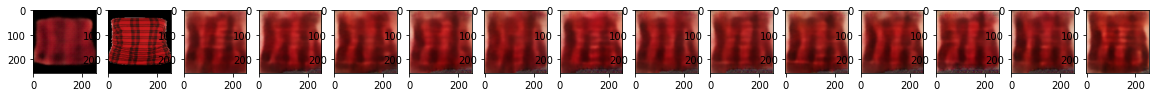

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


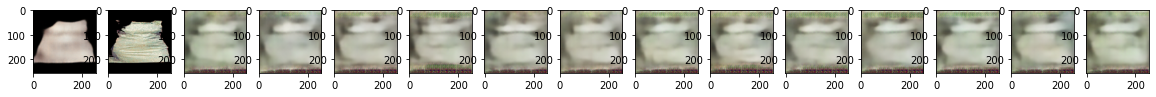

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


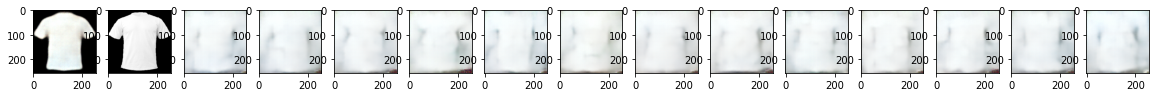

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


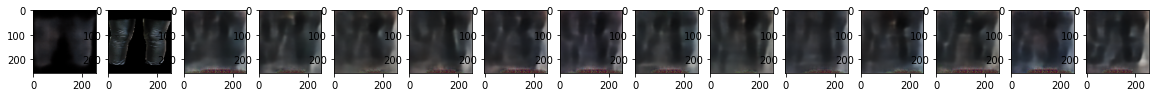

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


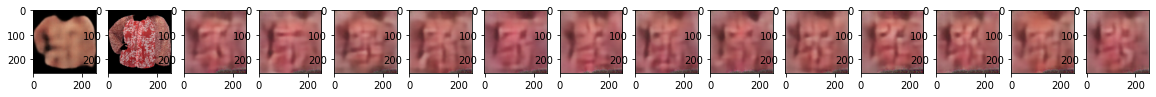

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


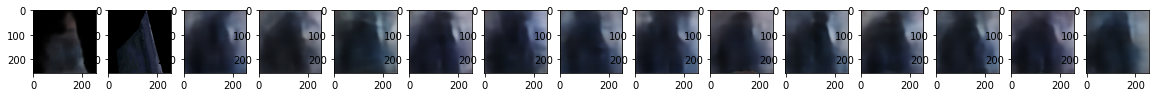

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


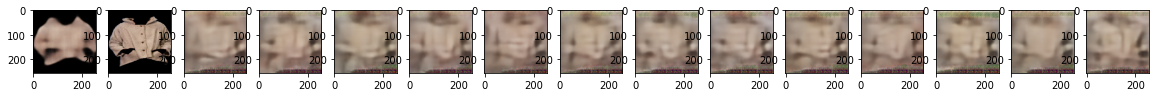

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


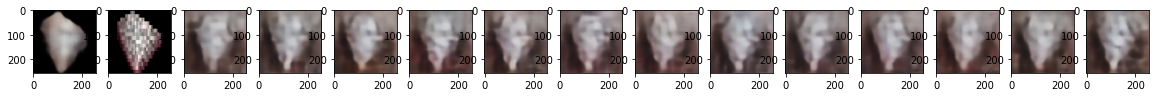

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


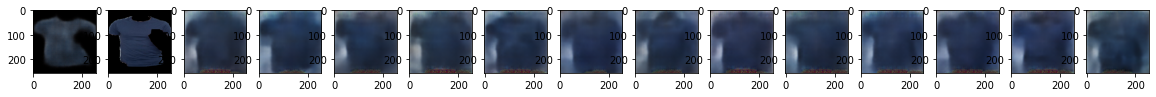

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


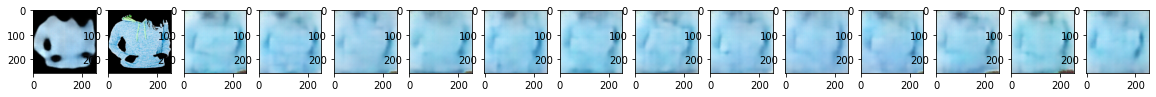

In [ ]:
for i in range(10):
  plt.figure(figsize=(20,4))
  plt.subplot(1,15,1)
  plt.imshow(y_pred[i])
  plt.subplot(1,15,2)
  plt.imshow(batch[0][i])
  for j in range(13):
    plt.subplot(1,15,j+3)
    plt.imshow(np.clip(y_pred_cat[j][i],0,1))
  plt.show()

In [ ]:
encoder = Model(inputs =autoencoder.inputs[0],outputs=autoencoder.get_layer('z_mean').output)
masked_encoder = Model(inputs =masked_autoencoder.inputs[0],outputs=masked_autoencoder.get_layer('z_mean').output)
#decoder = Model(inputs =autoencoder.get_layer('decoder').inputs,outputs=autoencoder.get_layer('decoder').outputs)

In [ ]:
y_val_true = np.concatenate([next(val_gen)[0] for i in range(len(val_gen))],axis=0)
y_val_true_cats = np.concatenate([next(val_gen)[1] for i in range(len(val_gen))],axis=0)

In [ ]:
y_val_pred,enocode_val_pred = autoencoder.predict(x=[y_val_true,y_val_true_cats],batch_size=64)
y_val_pred_masked,enocode_val_pred_masked = masked_autoencoder.predict(x=[y_val_true,y_val_true_cats],batch_size=64)
#enocode_train_pred = encoder.predict(train_gen,steps=len(train_gen))

In [ ]:
y_train_true = np.concatenate([next(train_gen)[0] for i in range(len(train_gen))],axis=0)
y_train_true_cats = np.concatenate([next(train_gen)[1] for i in range(len(train_gen))],axis=0)

# Visualize similarity search

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=10, p=3)
neigh.fit(enocode_val_pred)
neigh_masked = NearestNeighbors(n_neighbors=5, radius=10, p=3)
neigh_masked.fit(enocode_val_pred_masked)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=3,
                 radius=10)

In [ ]:
neighbours = neigh.kneighbors(enocode_val_pred[10:15], 10, return_distance=True)
neighbours_masked = neigh_masked.kneighbors(enocode_val_pred_masked[10:15], 10, return_distance=True)

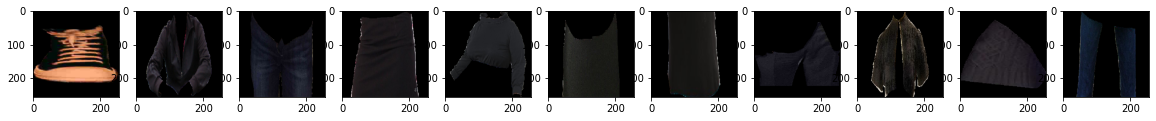

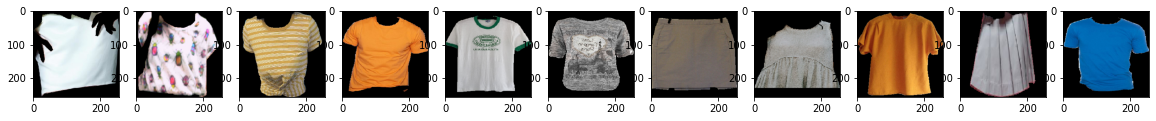

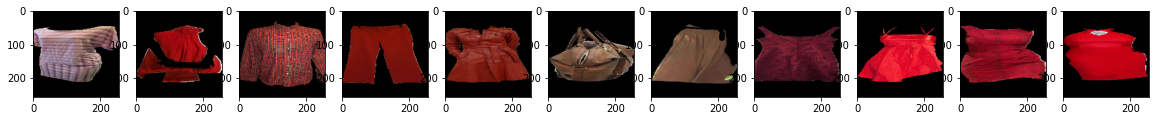

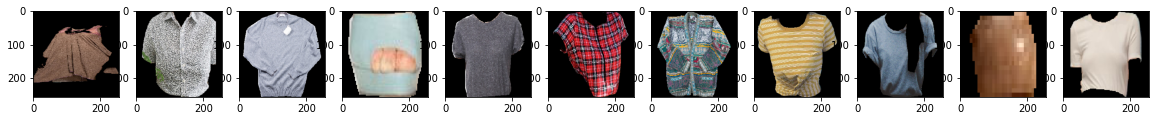

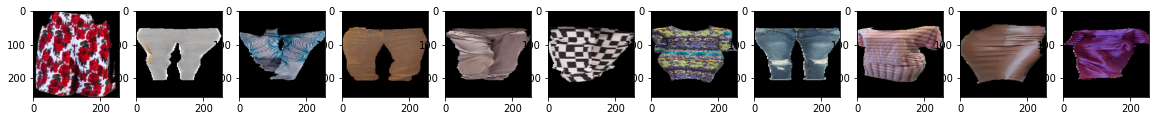

In [ ]:
for i in range(5):
  plt.figure(figsize = (20,4))
  plt.subplot(1,11,1)
  plt.imshow(y_val_true[i])
  for j in range(10):
    index = neighbours[1][i,j]
    plt.subplot(1,11,j+2)
    plt.imshow(y_val_true[index])

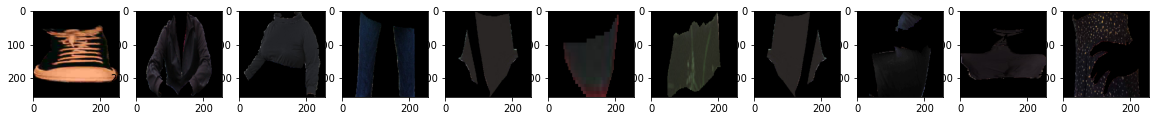

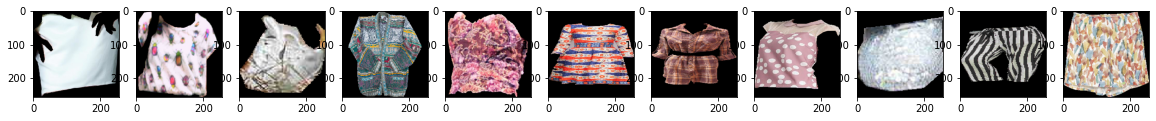

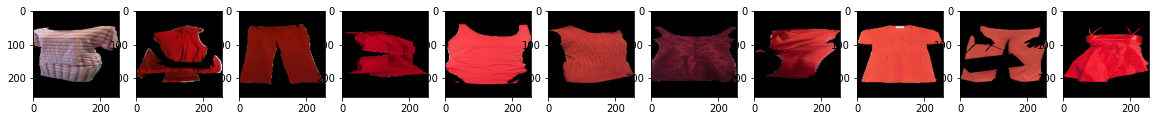

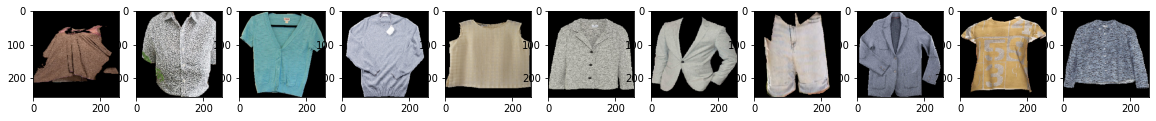

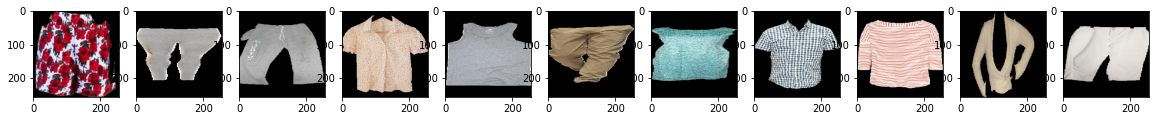

In [ ]:
for i in range(5):
  plt.figure(figsize = (20,4))
  plt.subplot(1,11,1)
  plt.imshow(y_val_true[i])
  for j in range(10):
    index = neighbours_masked[1][i,j]
    plt.subplot(1,11,j+2)
    plt.imshow(y_val_true[index])